In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import logging

from ElectionForecasting.src.modelling.DataLoader import DataLoader
from ElectionForecasting.src.utils.backtesting_utilities import (
    transform_obs_series, calculate_national_results,
    calculate_provincial_results,
    save_results, get_final_day_provincial_results
)
from ElectionForecasting.src.utils.plotting_utils import (
    plot_log_loss, violin_plot, plot_prob_band,
    close_figure, combined_scatter_and_traces
)
from ElectionForecasting.src.visualisations.electoral_map import \
    plot_election_map
from ElectionForecasting.src.config import (
    party_order, province_order, DATE_TODAY
)
from ElectionForecasting.src.root import ROOT_DIR

from ElectionForecasting.src.utils.general import (
    configure_logging, create_directory
)
from ElectionForecasting.src.utils.backtesting_utilities import (
    initialize_driver_and_data, fit_and_predict
)
from matplotlib.pyplot import savefig


INFO:root:SETTING DATE TO 2023-10-29


In [2]:
import pymc as pm
import pytensor.tensor as pyt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ElectionForecasting.src.modelling.DataLoader import DataLoader
from ElectionForecasting.src.root import ROOT_DIR
from ElectionForecasting.src.modelling.DatalandElectionModel import (
    add_coordinates, add_data,
    get_lagged_mu_contribution,
    linear_combination_of_vote_share,
    proportion
)
from ElectionForecasting.src.utils.backtesting_utilities import initialize_driver_and_data

In [3]:
data_loader = DataLoader()
y = '2023'
driver = initialize_driver_and_data(y, data_loader)
(gam_forecasts_df, train_df, vote_shares, previous_year_pleans) = (
    driver.gam_forecast, driver.train, driver.state_train, driver.previous_year_pleans
)

INFO:root:Initializing Driver object.
INFO:root:Loading pleans.
INFO:root:Loading state results.
INFO:root:Loading model inputs.
INFO:root:Loading GAM forecasts.
INFO:root:Loading pleans correlations.
INFO:root:Setting random seed to 123.
INFO:root:Building build_modelthe model.
INFO:root:Transforming input data.
INFO:root:Retrieving GAM forecast for 2023.
INFO:root:Performing categorical transformations.
INFO:root:Performing categorical transformations.


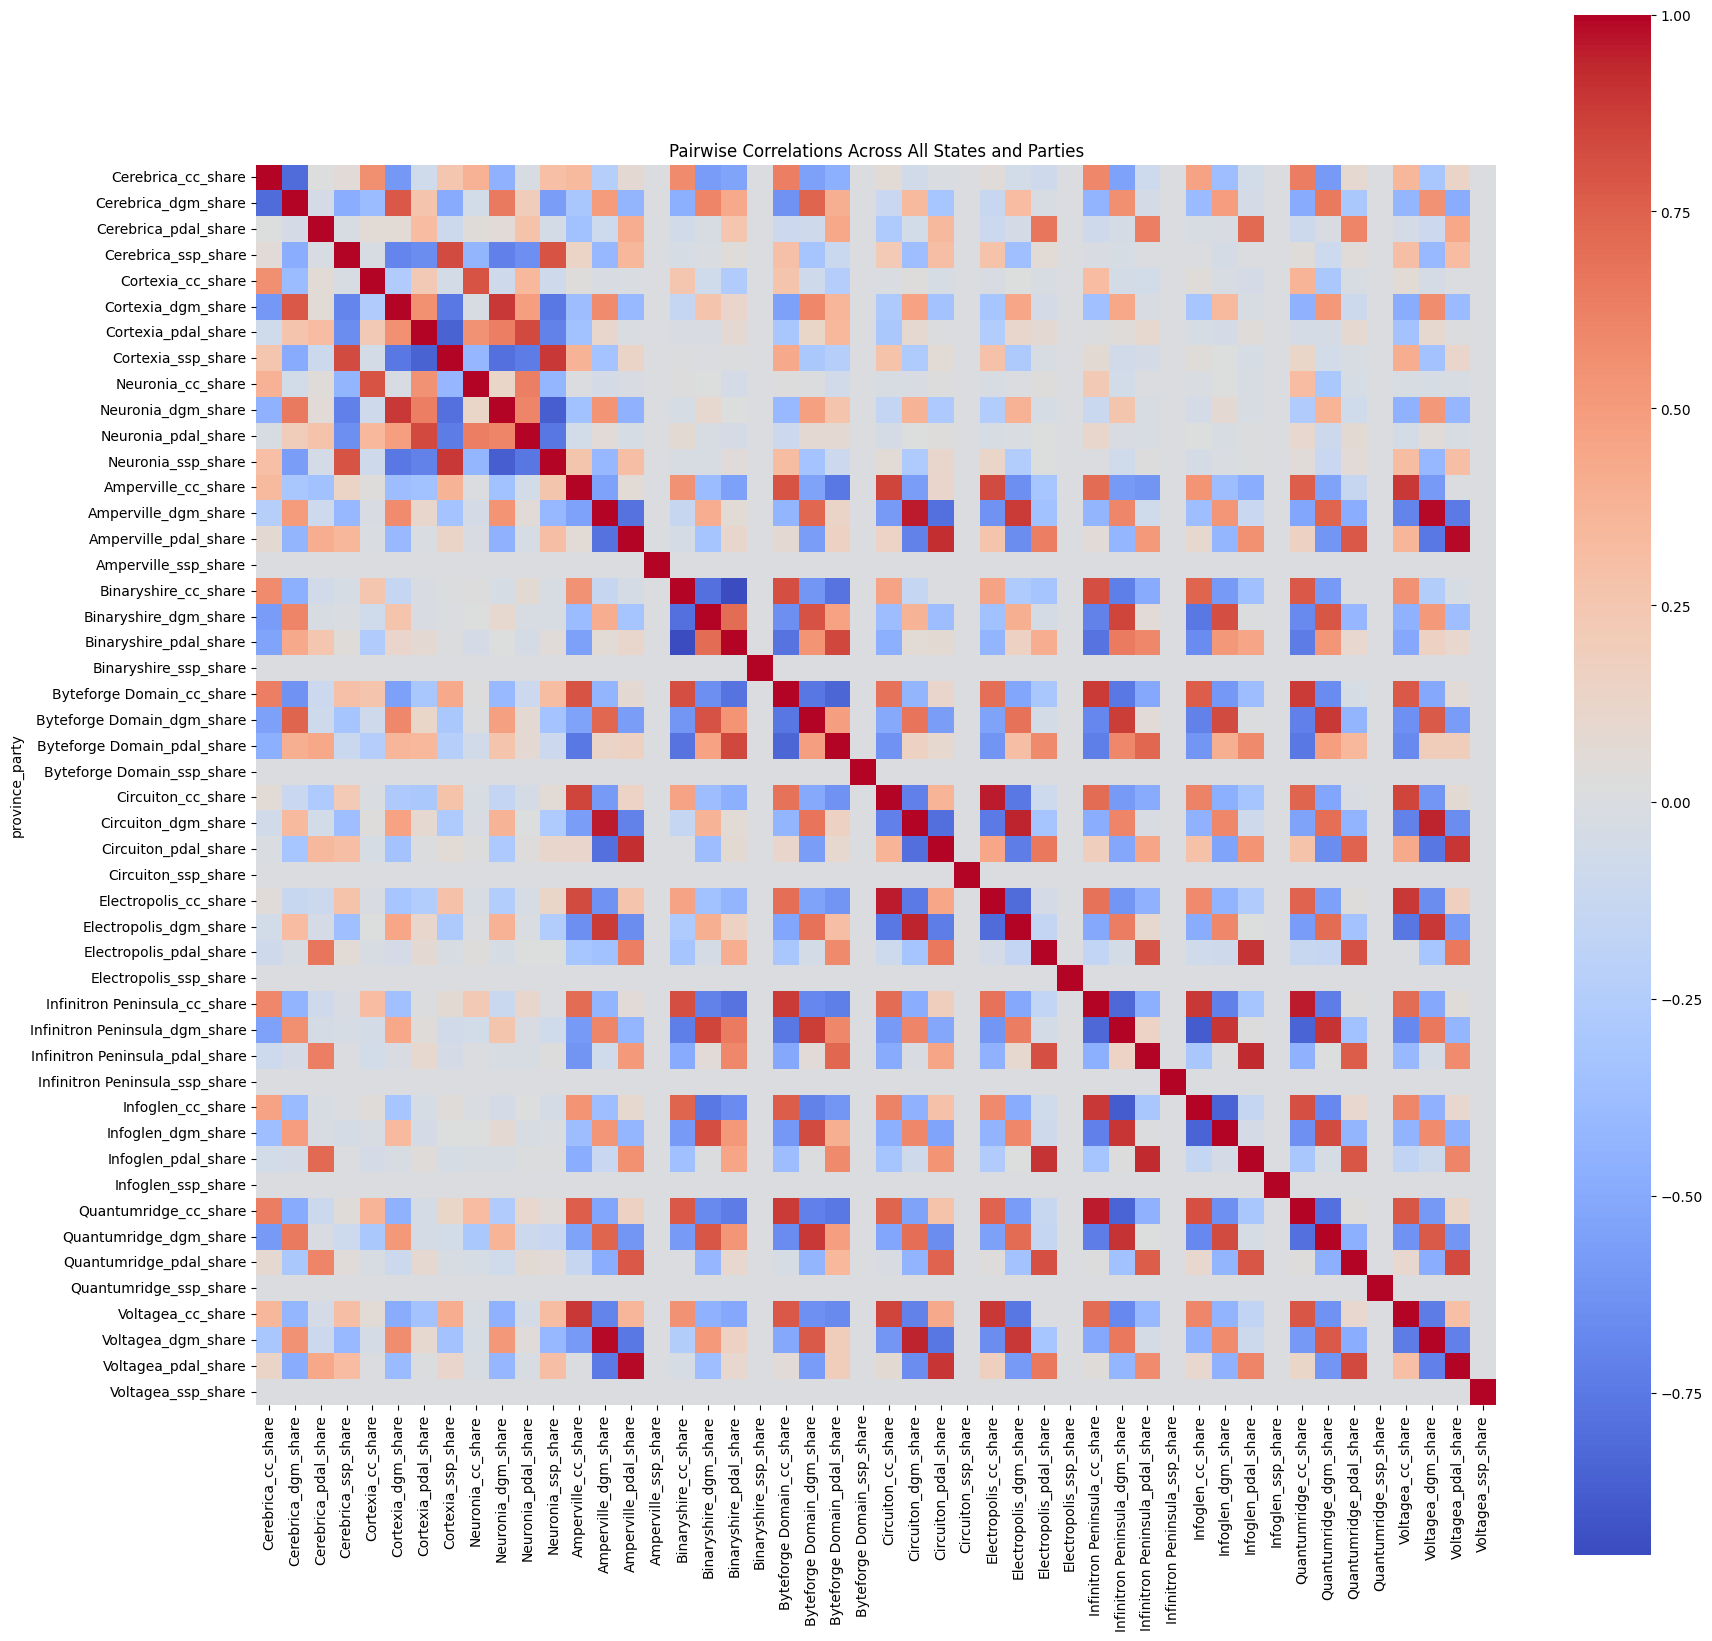

In [4]:
def plot_heatmap(df, title='Pairwise Correlations Across All States and Parties'):
    # Plot the large correlation matrix as a heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(df.fillna(0), annot=False, cmap='coolwarm', cbar=True, square=True)
    plt.title(title)
    # plt.show()
def matrix_anti_transpose(M, labels):
    # To flip the matrix along its secondary diagonal
    inverted_corr_matrix = np.transpose(np.flip(M.T, axis=0))
    inverted_labels = labels[::-1]
    return inverted_corr_matrix, inverted_labels
import pandas as pd
def df_anti_transpose(df):
    labels = df.index
    M = df.values
    inv, inv_labels = matrix_anti_transpose(M, labels)
    inverted = pd.DataFrame(inv, index=labels, columns=labels[::-1])
    return inverted
corr = pd.read_csv(f'{ROOT_DIR}/data/processed/state_vote_correlations.csv', index_col=0)
cov = pd.read_csv(f'{ROOT_DIR}/data/processed/state_vote_covariance.csv', index_col=0)
plot_heatmap(corr)
plt.show()

In [5]:
import numpy as np
from scipy.stats import gmean
n_states = 12
n_parties = 4
trf_pleans = []
for year, plean in driver.dl.pleans.items():
    if year >= y:
        continue
    trf_pleans.append(np.log(plean.values / gmean(plean.values+1e-10, axis=0)))
trf_pleans = np.concatenate(trf_pleans, axis=0)

/home/ae_linux/Projects/ElectionForecastingFinal/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:197: RuntimeWarning:

invalid value encountered in log



In [6]:
def linear_combination_of_vote_share(
        t, n_time_points, gam_forecasts, observed_vote_share,
        switchpoint_min, switchpoint_max
    ):
    switchpoint_diff = switchpoint_max - switchpoint_min
    # change the bounds of the linear function
    norm_t = alpha_switch_min + switchpoint_diff * (t/n_time_points)
    a = gam_forecasts* norm_t[:, None, None] # gam_forecasts * norm_t[None,:,None]
    b = observed_vote_share[None,:] * (1-norm_t)[:,None, None]
    daily_obs_vote_share_state_wise = a+b
    return daily_obs_vote_share_state_wise

with pm.Model(coords={'all_days_till_the_election': gam_forecasts_df.index[::-1]}) as model:
    ### Welcome to the world of probabilistic programming.
    ### please leave your coats, shoes, and singularly defined
    ### variables at the door.

    # Prepare the PyMC model context
    add_coordinates(model, train_df, gam_forecasts_df)
    add_data(
        gam_forecasts_df.iloc[:,:4].values,
        vote_shares,
        previous_year_pleans
    )
    # A binary mask to distinguish between parties that do and do not contest in each province
    does_compete = model['does_compete']

    # Time for change section of the model
    alpha_prior_mean = np.full((4, ), .25)
    sigma_prior_mean = np.full((4, ), .25)
    alphas = pm.Normal('alphas', mu=alpha_prior_mean,  sigma=sigma_prior_mean)
    lagged_contributions = get_lagged_mu_contribution(train_df, lag=3)
    mus = pm.Deterministic('mus', pm.math.exp(alphas + lagged_contributions))
    dirichlet_alphas = pm.Deterministic('dirichlet_alphas', mus)

    # Fundamentals based national vote share prediction
    observed_vote_share = pm.Dirichlet('observed_vote_share', a=dirichlet_alphas, observed=model['y_data']) 

    # Combination of fundamentals based prediction with polling data
    poll_forecasts = model['gam_forecasts']
    time_for_change_prior = observed_vote_share.mean(axis=0)[None, :]
    n_days_of_polling = model.dim_lengths['polling_date']
    n_time_points = model.dim_lengths['all_days_till_the_election']
    t = pyt.arange(1, n_time_points + 1)
    t = t[-n_days_of_polling:]
    # Define the max and min for alpha switching
    # These can be replaced by RVs for a more Bayesian approach
    alpha_switch_max = 0.85
    alpha_switch_min = 0.35

    # I weight the parties national vote share since the SSP's nationally
    # observed polling results should be proportionally increased in the
    # states in which they do compete. This is a flawed assumption, and 
    # warrants more attention.
    does_compete_national = does_compete.mean(axis=0)
    poll_forecasts_state_wise = (
            poll_forecasts[:, None, :] *
            (does_compete_national*does_compete)[None, :]
    )

    # using a linear function to combine these predictors. Can adapt to
    # more complex functions.
    daily_obs_vote_share_state_wise = pm.Deterministic(
        'daily_obs_vote_share',
            linear_combination_of_vote_share(
                t, n_time_points, poll_forecasts_state_wise,
                time_for_change_prior,
                switchpoint_min=alpha_switch_min,
                switchpoint_max=alpha_switch_max
        )
    )

    # # The state specific vote shares is then taken as the sum of the previous
    # # year's partisan leans and the observed national vote share projections.
    # # Incorporating the covariance martix into this calculation induced significant
    # # model instability, and adversely affected model results, so was omitted, however
    # # this is worth more attention.
    # partisan_leans = model['previous_year_pleans'] 
    # pm.Deterministic('state_vote_share', 
    #                     proportion(
    #                             daily_obs_vote_share_state_wise +
    #                             (
    #                                 partisan_leans[None, :, :] *
    #                                 does_compete[None, :, :]
    #                             )
    #                         )*does_compete[None, :, :])
    # trace = pm.sample()

    # sd_dist = pm.Exponential.dist(1.0, shape=48)
    # (chol, corr, stds) = pm.LKJCholeskyCov('chol_cov', n=48, eta=2., sd_dist=sd_dist)
    # cov = chol.dot(chol.T)
    # cov = pm.Deterministic('cov', cov)
    # corr = pm.Deterministic('corr', corr)
    # pm.Deterministic('chol', chol)
    partisan_leans = model['previous_year_pleans'] 
    mu = pm.Normal('mu', mu=0, sigma=1, shape=n_parties)
    # packed_chol = pm.LKJCholeskyCov('packed_chol', n=n_parties, eta=2., sd_dist=pm.Exponential.dist(1))
    # chol = pm.expand_packed_triangular(n_parties, packed_chol)
    # cov = pm.Deterministic('cov', chol.dot(chol.T))  # Full covariance matrix
    # sd_dist = pm.Exponential.dist(1.0, shape=48)
    # (chol, corr, stds) = pm.LKJCholeskyCov('chol_cov', n=48, eta=2., sd_dist=sd_dist)
    # cov = chol.dot(chol.T)
    # cov = pm.Deterministic('cov', cov)
    # corr = pm.Deterministic('corr', corr)
    # pm.Deterministic('chol', chol)
    # # Multivariate Normal
    # mvn = pm.MvNormal('mvn', mu=pyt.tile(mu, (n_states, 1)), chol=pyt.tile(chol, (n_states, 1, 1)), observed=trf_pleans)
    # flat_partisan_leans = pyt.exp(mvn) / pyt.sum(pyt.exp(mvn), axis=1, keepdims=True)

    flat_partisan_leans = pm.MvNormal('flat_partisan_leans', 
                                      mu=np.zeros(48),
                                    #   mu=previous_year_pleans.reshape((-1,)), 
                                      cov=corr, 
                                    #  cov=np.eye(48),  
                                    #   cov=np.flip(cov.T),
                                    #   observed=previous_year_pleans.reshape((-1,)), 
                                      shape=(48))
    # reshaped_partisan_leans = flat_partisan_leans.mean(axis=0).reshape((12, 4))
    reshaped_partisan_leans = flat_partisan_leans.reshape((12, 4))
    zerosum_partisan_leans = (proportion(reshaped_partisan_leans.eval()) - .25)
    partisan_leans = zerosum_partisan_leans
    # partisan_leans = pleans # pm.Deterministic('partisan_leans', pleans)
    vote_share_per_state = pm.Deterministic('state_vote_share', 
                    proportion(daily_obs_vote_share_state_wise + (partisan_leans[None, :, :] * does_compete[None, :, :]))*does_compete[None, :, :])

    # pm.Deterministic('state_vote_share', combined_state_votes)
    trace = pm.sample(target_accept=1e-1)
    # trace = pm.sample(target_accept=.95, cores=4, tune=1000, nuts_sampler_kwargs={"nuts": {"max_tree_depth":100, 'step_scale': 40}})
    # step_scale = 1/n^{1/4} so since i have higher dimensional data, a larger step size is justified.


INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [alphas, alpha_party_lag_3q, alpha_pop_vote_lag_3q, betas_gdp_lag_3q, betas_inflation_lag_3q, betas_stk_mkt_lag_3q, betas_unemployment_lag_3q, mu, flat_partisan_leans]


INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 166 seconds.
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:There were 3984 divergences after tuning. Increase `target_accept` or reparameterize.


INFO:root:Initializing Driver object.
INFO:root:Loading pleans.
INFO:root:Loading state results.
INFO:root:Loading model inputs.
INFO:root:Loading GAM forecasts.
INFO:root:Loading pleans correlations.
INFO:root:Setting random seed to 123.
INFO:root:Building build_modelthe model.
INFO:root:Transforming input data.
INFO:root:Retrieving GAM forecast for 2023.
INFO:root:Performing categorical transformations.
INFO:root:Performing categorical transformations.
INFO:pymc.sampling.forward:Sampling: [observed_vote_share, party_effect_lag_3q, pop_vote_lag_3q]


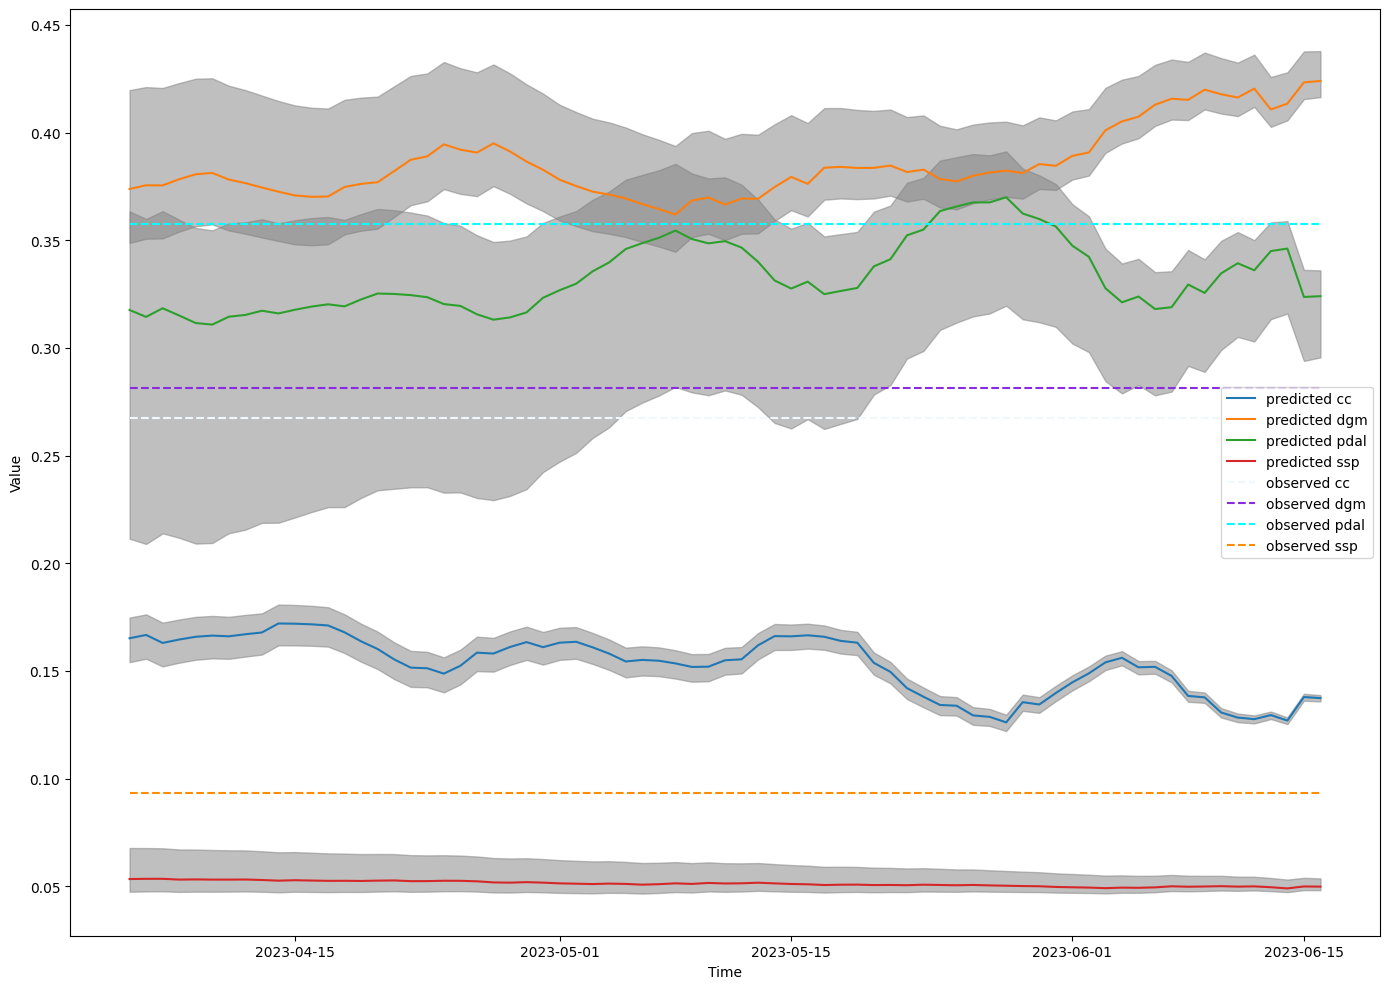

In [7]:
from ElectionForecasting.src.utils.backtesting_utilities import (
    initialize_driver_and_data, fit_and_predict
)
import pandas as pd
from ElectionForecasting.src.config import party_order, province_order
from ElectionForecasting.src.utils.plotting_utils import plot_prob_band

# Initialize driver and data
driver = initialize_driver_and_data(y, data_loader)
driver.model = model
driver.trace = trace
# Fit and predict
predictive_samples = driver.check(sample_posterior_predictive_kwargs={})
predictive_samples = predictive_samples.posterior_predictive.\
    state_vote_share.values
predictive_samples = predictive_samples.reshape(
    ([-1] + list(predictive_samples.shape[-3:]))
)
posterior_samples = predictive_samples.mean(axis=2)
observations = pd.DataFrame(
    [driver.state_test[0].mean(axis=0)], columns=party_order
).T
plot_prob_band(
    predictions=posterior_samples, observed=observations,
    time_index=pd.to_datetime(
        driver.model.coords['polling_date'])[::-1]
)
plt.show()

Showing plot...


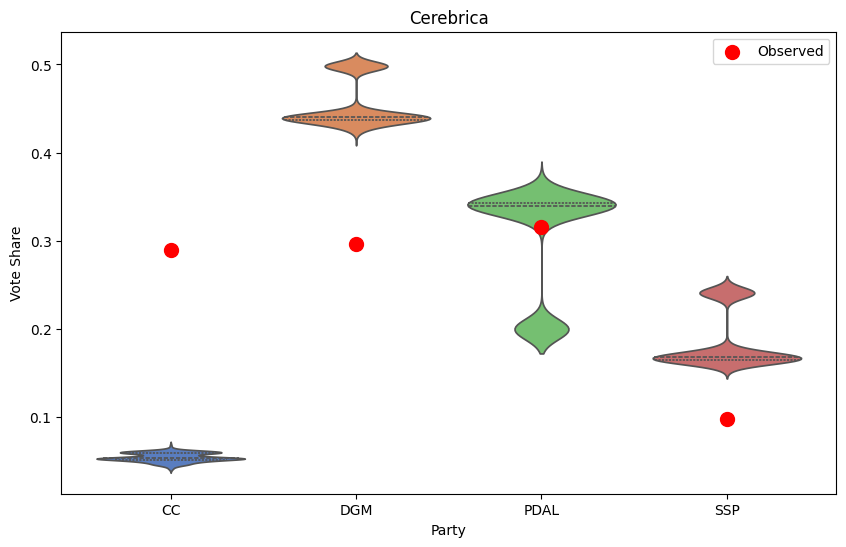

Showing plot...


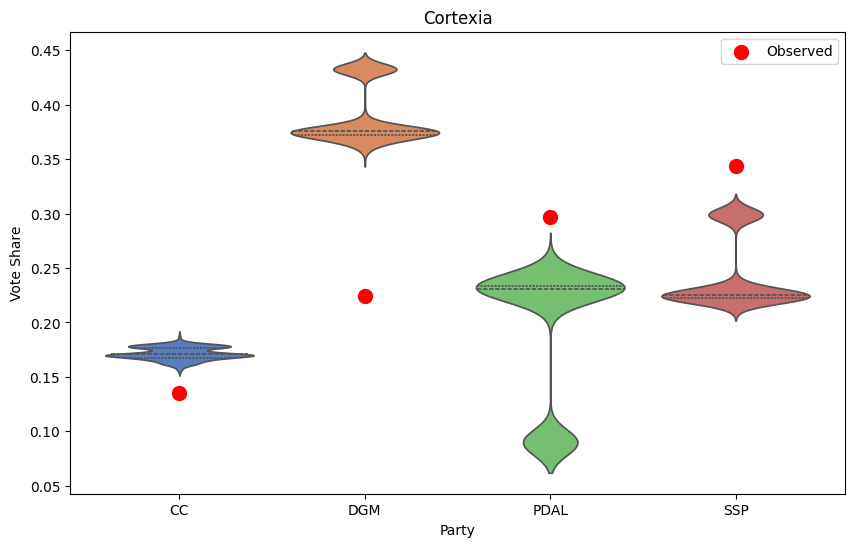

Showing plot...


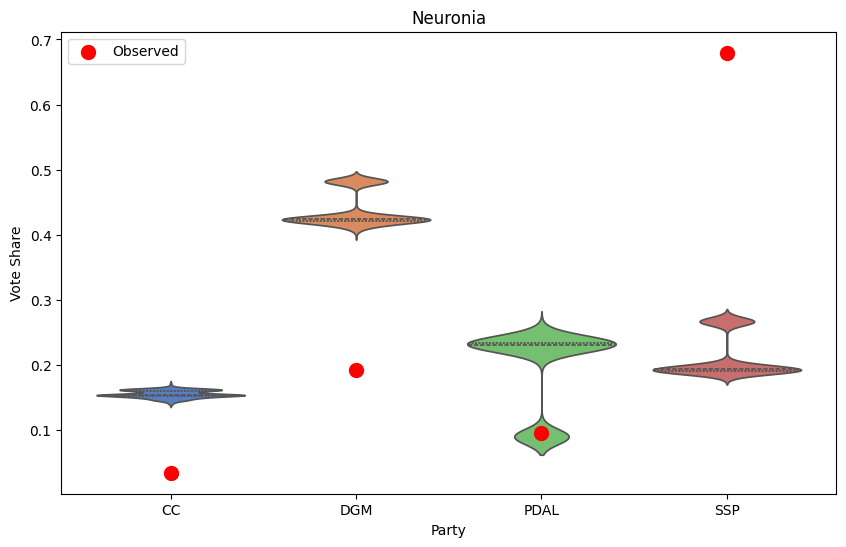

Showing plot...


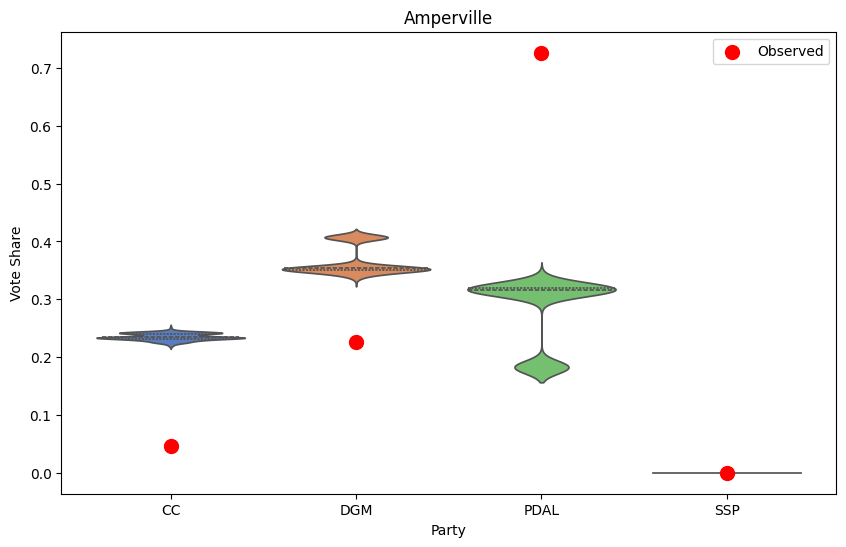

Showing plot...


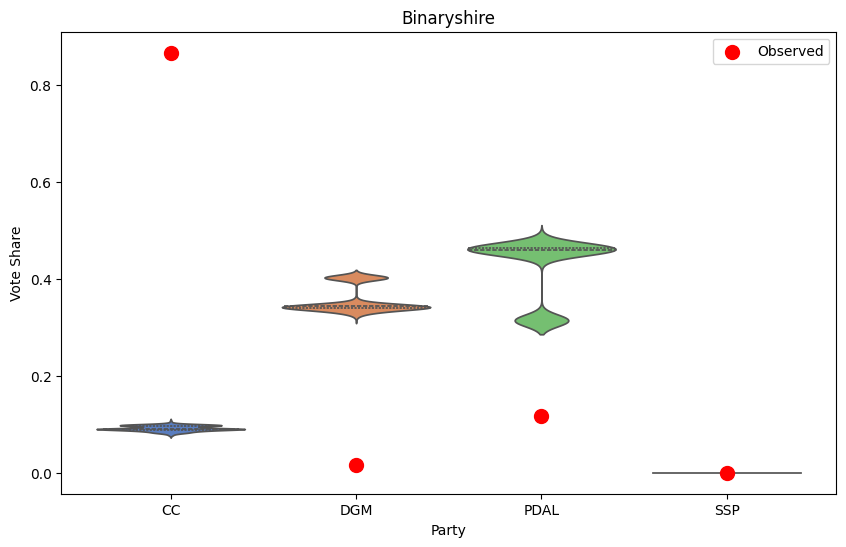

Showing plot...


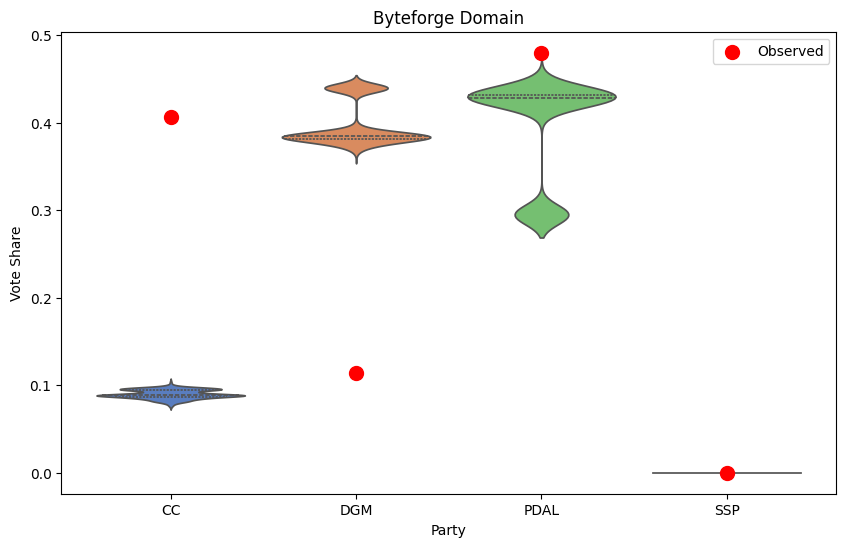

Showing plot...


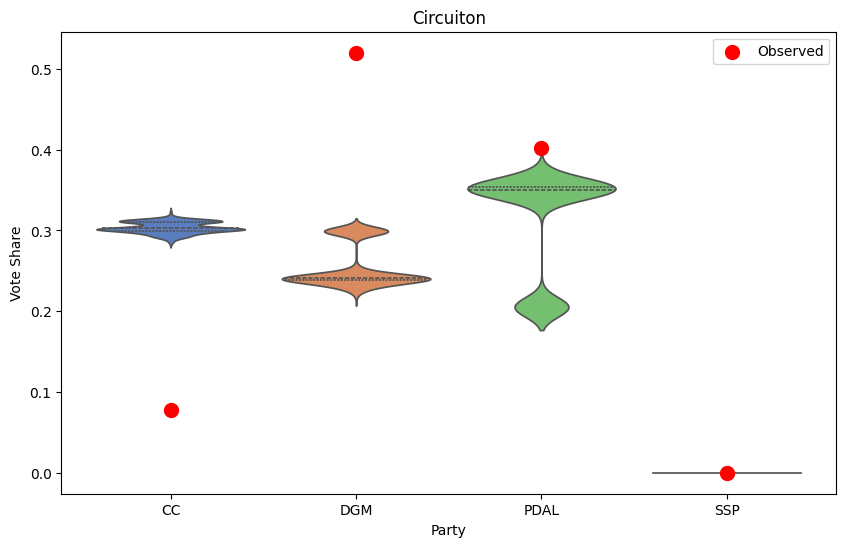

Showing plot...


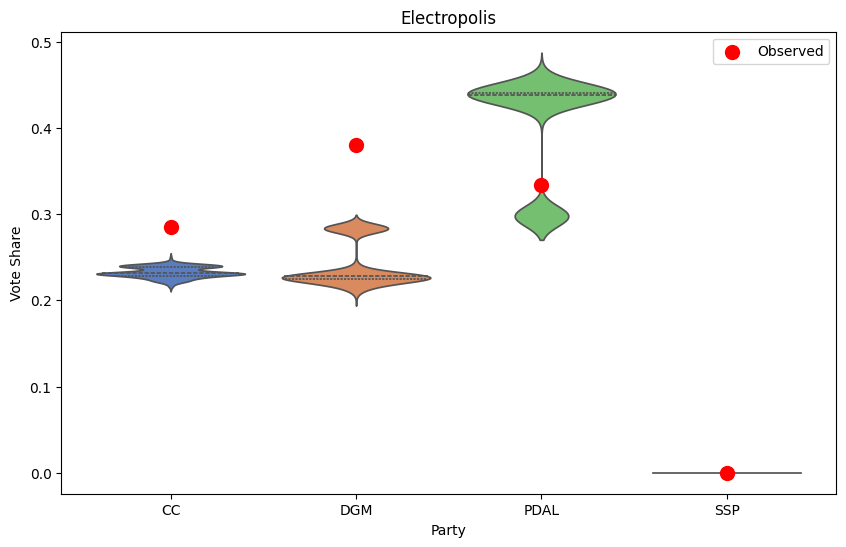

Showing plot...


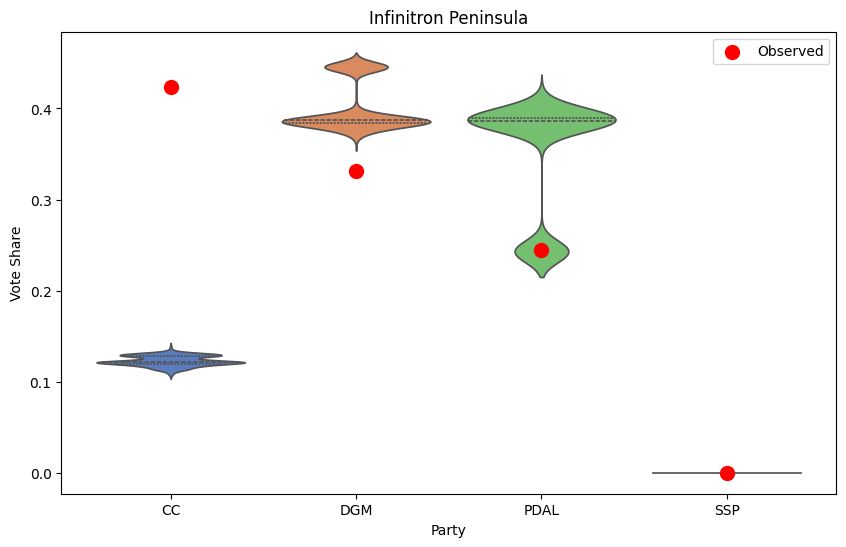

Showing plot...


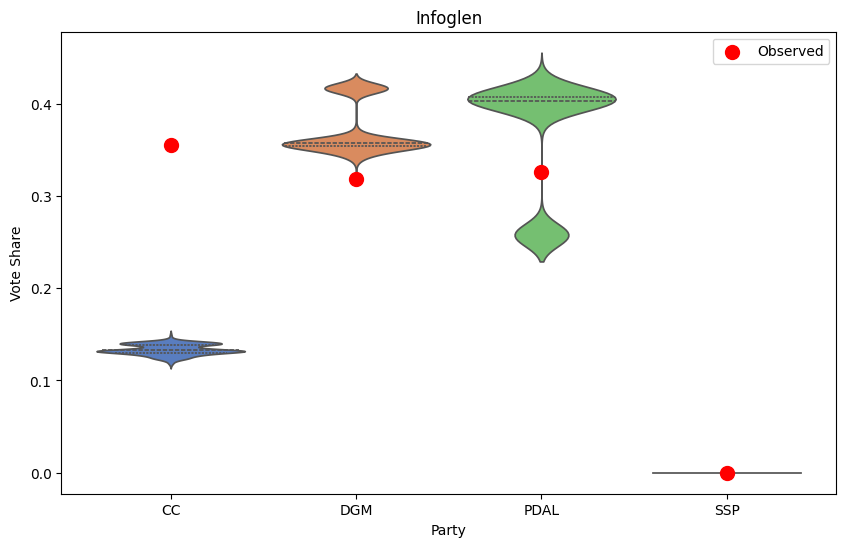

Showing plot...


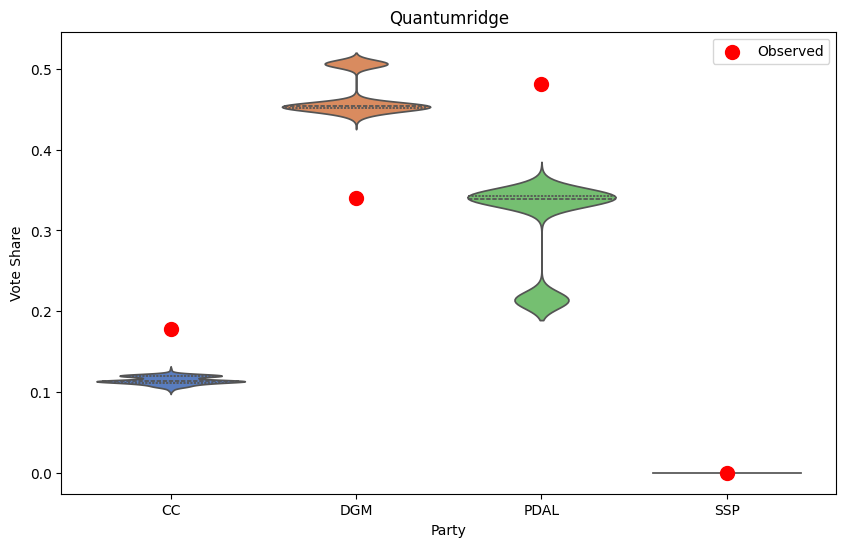

Showing plot...


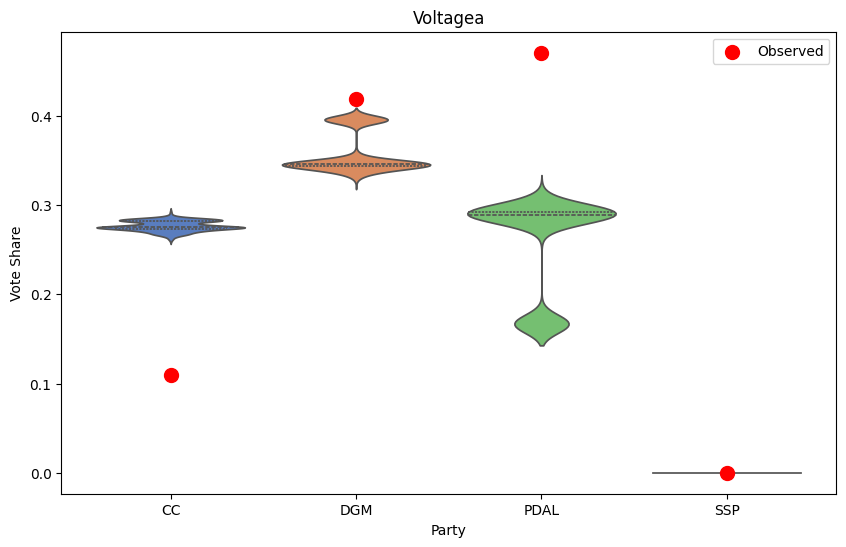

In [8]:

# Loop through the provinces and create violin plots
for i, province_name in enumerate(province_order):
    
    # Prepare observed data for provincial-level violin plot
    observations = transform_obs_series(
        pd.Series(driver.target_state_votes
                    .loc[province_order].values[i],
                    index=[p.upper() for p in party_order])
    )

    # Generate and save the violin plot at the provincial level
    violin_plot(observations, predictive_samples[:, 0, :][:, i, :],
                title=f'{province_name}')
    close_figure(None, save_function=savefig, directory='',
                    filename=f'violin_{province_name}', save=False, show=True)
